Copyright (c) 2024 Graphcore Ltd. All rights reserved.

# u-muP demo

This notebook walks through the definition and training of a byte-level language model, comparing the [Unit-Scaled Maximal Update Parametrization](https://openreview.net/forum?id=44NKKzz1n5) "u-μP" against Standard Parametrization "SP" on learning-rate transfer across width.

We show:
 - How to define a u-μP model.
 - The forward and backward-pass scaling properties of a u-μP transformer decoder layer, versus an SP layer.
 - Learning rate transfer when training a u-μP model.

## Preamble

In [1]:
from typing import *

import datasets
import einops
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm

import torch
from torch import nn, Tensor
import torch.nn.functional as F

import unit_scaling as uu
import unit_scaling.functional as U

# Config & helpers
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
def show_layer_stats(layer: nn.Module, input_shape: Tuple[int, ...]) -> None:
    input = torch.randn(*input_shape, requires_grad=True)
    output = layer(input)
    output.backward(torch.randn_like(output))
    print(f"{type(layer).__name__}:")
    for k, v in {
        "output": output.std(),
        "input.grad": input.grad.std(),
        **{f"{name}": param.std() for name, param in layer.named_parameters()},
        **{f"{name}.grad": param.grad.std() for name, param in layer.named_parameters()},
    }.items():
        print(f"{k:>20}.std = {v.item():.2f}")

## Settings and dataset

Our experiments concern byte-level (UTF-8) causal language modelling on the [WikiText-103-raw](https://arxiv.org/abs/1609.07843) dataset, using small models and short training runs, for demonstration purposes. Note that many desirable features are missing, especially with regards validation and generation, as our focus is on the training behaviour.

In [47]:
# Model
vocab_size = 256
depth = 4
head_size = 64
mlp_expansion = 4

# Training
n_steps = int(5e3)
batch_size = 16
sequence_length = 256
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
compile = True

Concatenate the dataset into a single byte array, encoded as UTF-8, and sample training batches with replacement.

In [3]:
dataset = datasets.load_dataset("Salesforce/wikitext", "wikitext-103-raw-v1", split="train", download_config=datasets.DownloadConfig(disable_tqdm=True))
data = torch.frombuffer(bytearray("".join(dataset["text"]), encoding="utf8"), dtype=torch.uint8)
def batches() -> Iterable[Tensor]:
    for _ in range(n_steps):
        yield torch.stack([
            data[i:i + sequence_length].to(device=device, dtype=torch.long)
            for i in torch.randint(0, len(data) - sequence_length, size=(batch_size,))
        ])

## Model definition (SP)

We define a simple baseline model: [Transformer decoder](https://arxiv.org/abs/1706.03762), [PreNorm](https://arxiv.org/abs/1910.05895), [SwiGLU](https://arxiv.org/abs/2002.05202), [NoPE](https://arxiv.org/abs/2305.19466), no bias, no trainable norms.

In [ ]:
class SpTransformerLayer(nn.Module):
    def __init__(self, width: int) -> None:
        super().__init__()
        self.attn_norm = nn.LayerNorm(width, elementwise_affine=False)
        self.attn_qkv = nn.Linear(width, 3 * width, bias=False)
        self.attn_out = nn.Linear(width, width, bias=False)

        self.mlp_norm = nn.LayerNorm(width, elementwise_affine=False)
        self.mlp_up = nn.Linear(width, mlp_expansion * width, bias=False)
        self.mlp_gate = nn.Linear(width, mlp_expansion * width, bias=False)
        self.mlp_down = nn.Linear(mlp_expansion * width, width, bias=False)

    def forward(self, input: Tensor) -> Tensor:
        residual = self.attn_norm(input)
        q, k, v = einops.rearrange(self.attn_qkv(residual), "b s (z h d) -> z b h s d", d=head_size, z=3)
        qkv = F.scaled_dot_product_attention(q, k, v, is_causal=True)
        residual = self.attn_out(einops.rearrange(qkv, "b h s d -> b s (h d)"))
        input = input + residual

        residual = self.mlp_norm(input)
        residual = self.mlp_down(self.mlp_up(residual) * F.silu(self.mlp_gate(residual)))
        return input + residual


class SpTransformerDecoder(nn.Sequential):
    def __init__(self, width: int) -> None:
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, width)
        self.layers = nn.Sequential(*(SpTransformerLayer(width) for _ in range(depth)))
        self.final_norm = nn.LayerNorm(width, elementwise_affine=False)
        self.projection = nn.Linear(width, vocab_size, bias=False)

    def loss(self, input_ids: Tensor) -> Tensor:
        logits = self(input_ids).float()
        return F.cross_entropy(
            logits[..., :-1, :].flatten(end_dim=-2), input_ids[..., 1:].flatten()
        )

Passing Gaussian random data (std=1) into our layer in both forward and backward passes, we can evaluate the "scaling behaviour" (standard deviation of forward and backward pass inputs and outputs), which shows:

 - Forward pass (output) and backward pass (input.grad) scale is preserved (std ~= 1).
 - Weight values are small (std < 1).
 - Weight gradients are large (std > 1).

While not an immediate problem for training, the scales of weight values and gradients can cause two problems:

 - The scale depends on model hyperparameters (especially width), which makes training dynamics vary as the model is made larger. This prevents hyperparameters such as learning rate from "transferring" from small to large models.
 - The scale can approach the dynamic range of low-precision formats, requiring formats with more exponent bits (e.g. `bfloat16` instead of `float16`).

These problems are addressed by u-μP.

In [4]:
show_layer_stats(SpTransformerLayer(128), (batch_size, sequence_length, 128))

SpTransformerLayer:
              output.std = 1.01
          input.grad.std = 1.01
     attn_qkv.weight.std = 0.05
     attn_out.weight.std = 0.05
       mlp_up.weight.std = 0.05
     mlp_gate.weight.std = 0.05
     mlp_down.weight.std = 0.03
attn_qkv.weight.grad.std = 3.95
attn_out.weight.grad.std = 6.12
  mlp_up.weight.grad.std = 5.82
mlp_gate.weight.grad.std = 5.93
mlp_down.weight.grad.std = 11.59


## Model definition (u-muP)

In order to convert our model definition to a u-μP model, we apply the following rules:

```python
import unit_scaling as uu
import unit_scaling.functional as U
```

Replace:
 - Modules `nn.*` with `uu.*`, for example `nn.Linear -> uu.Linear`.
 - Any final projection(s) with `uu.LinearReadout`.
 - Functional calls `F.*` with `U.*`.
 - Residual patterns `x = x + fn(x)` with `U.residual_split` and `U.residual_add`.
   - These require a `tau` value, to weight the residual versus skip contributions. A recommended scheme for choosing `tau` is described in the paper, and implemented in `uu.transformer_residual_scaling_rule()`.
 - A "depth" hyperparameter scaling container with `uu.Stack` or `uu.DepthModuleList`.

In [ ]:
class UmupTransformerLayer(nn.Module):
    def __init__(self, width: int, layer_idx: int) -> None:
        super().__init__()
        self.attn_norm = uu.LayerNorm(width)
        self.attn_qkv = uu.Linear(width, 3 * width)
        self.attn_out = uu.Linear(width, width)

        self.mlp_norm = uu.LayerNorm(width)
        self.mlp_up = uu.Linear(width, mlp_expansion * width)
        self.mlp_gate = uu.Linear(width, mlp_expansion * width)
        self.mlp_down = uu.Linear(mlp_expansion * width, width)

        tau_rule = uu.transformer_residual_scaling_rule()
        self.attn_tau = tau_rule(2 * layer_idx, 2 * depth)
        self.mlp_tau = tau_rule(2 * layer_idx + 1, 2 * depth)

    def forward(self, input: Tensor) -> Tensor:
        residual, skip = U.residual_split(input, self.attn_tau)
        residual = self.attn_norm(residual)
        q, k, v = einops.rearrange(self.attn_qkv(residual), "b s (z h d) -> z b h s d", d=head_size, z=3)
        qkv = U.scaled_dot_product_attention(q, k, v, is_causal=True)
        residual = self.attn_out(einops.rearrange(qkv, "b h s d -> b s (h d)"))
        input = U.residual_add(residual, skip, self.attn_tau)

        residual, skip = U.residual_split(input, self.mlp_tau)
        residual = self.mlp_norm(residual)
        residual = self.mlp_down(U.silu_glu(self.mlp_up(residual), self.mlp_gate(residual)))
        return U.residual_add(residual, skip, self.mlp_tau)


class UmupTransformerDecoder(nn.Sequential):
    def __init__(self, width: int) -> None:
        super().__init__()
        self.embedding = uu.Embedding(vocab_size, width)
        self.layers = uu.Stack(*(UmupTransformerLayer(width, i) for i in range(depth)))
        self.final_norm = uu.LayerNorm(width)
        self.projection = uu.LinearReadout(width, vocab_size)

    def loss(self, input_ids: Tensor) -> Tensor:
        logits = self(input_ids).float()
        return U.cross_entropy(
            logits[..., :-1, :].flatten(end_dim=-2), input_ids[..., 1:].flatten()
        )

u-μP solves forward and backward pass scaling problems by computing scale-preserving multipliers in unit-scaled modules (`uu.*`) and functions (`U.*`).

These scaling rules must trade off forward and backward pass scaling accuracy in order to preserve gradient correctness, which means scale is approximately, not exactly, preserved.

In [6]:
show_layer_stats(UmupTransformerLayer(128, 0), (batch_size, sequence_length, 128))

UmupTransformerLayer:
              output.std = 1.00
          input.grad.std = 1.10
     attn_qkv.weight.std = 1.00
     attn_out.weight.std = 1.00
       mlp_up.weight.std = 1.00
     mlp_gate.weight.std = 1.00
     mlp_down.weight.std = 1.00
attn_qkv.weight.grad.std = 0.63
attn_out.weight.grad.std = 1.07
  mlp_up.weight.grad.std = 0.50
mlp_gate.weight.grad.std = 0.52
mlp_down.weight.grad.std = 1.01


## Learning rate transfer experiments

Training a u-μP model is much like training an SP model, using `uu.optim.*` in place of `torch.optim.*`.

u-μP optimizers are responsible for varying the learning rate based on categories of parameters in the model and the total depth of any depth-scaled layers. These categories are stored in `parameter.mup_type` and are automatically assigned by `uu.*` modules. Total depth is stored in `parameter.mup_scaling_depth` and assigned by `uu.Stack`.

**Note: the following cell takes many (more than 45) minutes to run.**

In [49]:
def run_experiment(type_: Literal["SP", "u-μP"], width: int, lr: float) -> List[Dict[str, Any]]:
    if type_ == "u-μP":
        model = UmupTransformerDecoder(width).to(device)
        opt = uu.optim.AdamW(model.parameters(), lr=lr)

    if type_ == "SP":
        model = SpTransformerDecoder(width).to(device)
        opt = torch.optim.AdamW(model.parameters(), lr=lr)

    def run_step(batch: Tensor) -> Tensor:
        opt.zero_grad()
        loss = model.loss(batch)
        loss.backward()
        opt.step()
        return loss

    if compile:
        torch.compiler.reset()
        run_step = torch.compile(mode="reduce-overhead")(run_step)

    log = []
    log2lr = torch.tensor(lr).log2().item()
    progress = tqdm(enumerate(batches()), desc=f"{type_}, width={width}, lr=2^{log2lr:.0f}")
    for step, batch in progress:
        loss = run_step(batch)
        log.append(dict(step=step, loss=loss.item()))
        progress.set_postfix_str(f"loss = {loss.item():.2f}")
    return pd.DataFrame.from_dict(log).assign(type=type_, width=width, lr=lr)


type_to_lr_range = {
    "SP": [2**n for n in range(-14, -8 + 1)],
    "u-μP": [2**n for n in range(-4, 2 + 1)],
}
df = pd.concat([
    run_experiment(type_=type_, width=width, lr=lr)
    for type_, lrs in type_to_lr_range.items()
    for width in [128, 512]
    for lr in lrs
]).reset_index()
df.to_json("demo.results.json")

SP, width=128, lr=2^-14: 5000it [00:40, 122.45it/s, loss = 2.37]
SP, width=128, lr=2^-13: 5000it [00:40, 123.63it/s, loss = 2.00]
SP, width=128, lr=2^-12: 5000it [00:40, 122.72it/s, loss = 1.74]
SP, width=128, lr=2^-11: 5000it [00:43, 116.11it/s, loss = 1.60]
SP, width=128, lr=2^-10: 5000it [00:40, 123.30it/s, loss = 1.63]
SP, width=128, lr=2^-9: 5000it [00:43, 116.24it/s, loss = 1.57]
SP, width=128, lr=2^-8: 5000it [00:40, 122.74it/s, loss = 2.42]
SP, width=512, lr=2^-14: 5000it [02:29, 33.47it/s, loss = 1.67]
SP, width=512, lr=2^-13: 5000it [02:31, 32.93it/s, loss = 1.48]
SP, width=512, lr=2^-12: 5000it [02:29, 33.52it/s, loss = 1.34]
SP, width=512, lr=2^-11: 5000it [02:31, 32.98it/s, loss = 1.36]
SP, width=512, lr=2^-10: 5000it [02:29, 33.51it/s, loss = 2.43]
SP, width=512, lr=2^-9: 5000it [02:31, 32.95it/s, loss = 2.47]
SP, width=512, lr=2^-8: 5000it [02:29, 33.48it/s, loss = 2.48]
u-μP, width=128, lr=2^-4: 5000it [00:48, 102.51it/s, loss = 1.79]
u-μP, width=128, lr=2^-3: 5000it [0

Transfer plots, showing that the optimal LR shifts for SP, but not for u-μP, as width is quadrupled from 128 to 512. This property is inherited from μP.

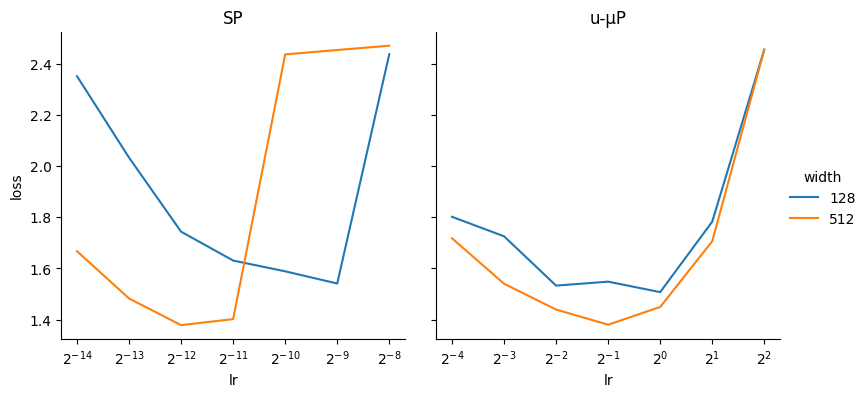

In [72]:
df_final = df.groupby(["type", "width", "lr"])["loss"].apply(lambda g: g.iloc[-50:].mean()).reset_index()

g = sns.relplot(data=df_final.pipe(lambda d: d.assign(width=d.width.apply(str))),
                y="loss", x="lr", hue="width", col="type", kind="line", facet_kws=dict(sharex=False), height=4)
for type, ax in g.axes_dict.items():
    ax.set_title(type)
    ax.set_xscale("log", base=2)

Training curves at the best LR.

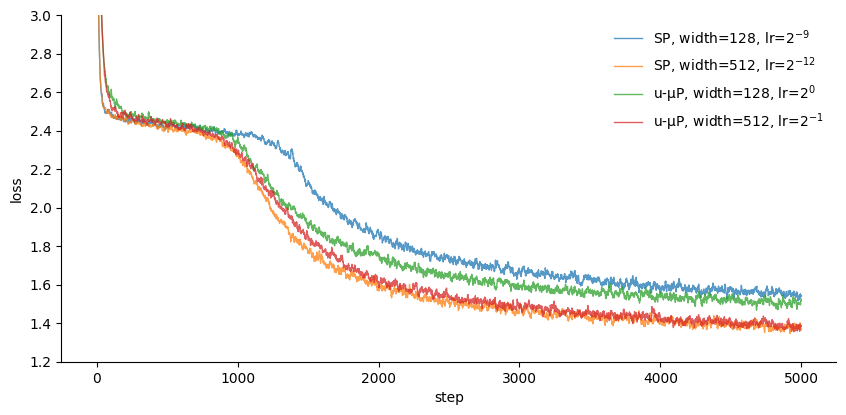

In [74]:
plt.figure(figsize=(10, 4.5))
ax = plt.gca()
for (type_, width), g in df.groupby(["type", "width"]):
    lr = df_final[(df_final["type"] == type_) & (df_final["width"] == width)].pipe(lambda d: d.lr.iloc[d.loss.argmin()])
    g = g[g.lr == lr]
    log2lr = torch.tensor(lr).log2().item()
    ax.plot(g.step, g.loss.ewm(com=5).mean(), label=f"{type_}, width={width}, lr=$2^{{{log2lr:.0f}}}$", lw=1, alpha=.75)
ax.legend(frameon=False)
ax.set_ylim((1.2, 3))
ax.set_xlabel("step")
ax.set_ylabel("loss")
sns.despine()